# Import function

In [1]:
import numpy as np
# import awkward
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
import numpy as np
import scipy.optimize as opt
import sys, os, random, gzip
import tensorflow as tf
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import keras
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from sklearn.model_selection import train_test_split
import sys
from sklearn import metrics
from keras.models import load_model
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as skAUC
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
import tensorflow as tf
from keras import backend as K
import time
import glob
from tqdm import tqdm

In [3]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def roc_plot(N, validation_split, model_name):
    dependencies = {'auc': auc}
    model = load_model(f'models/{model_name}.h5', custom_objects=dependencies)
    X_train, X_test, y_train, y_true = prep_data(N, validation_split)
    y_score=model.predict(X_test).T[0]  
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    bkg_eff = fpr
    sig_eff = tpr
    auc_val = roc_auc_score(y_true, y_score)
    bkg_rej = 1. - bkg_eff
    inv_bkg = np.divide(1.0, bkg_eff)
    print(model_name, auc_val)
    plt.plot(sig_eff, inv_bkg , linestyle='-', label=f'{model_name} - [AUC={auc_val:0.3}]', linewidth=2)
    plt.xlabel('Signal Efficiency')
    plt.yscale('log')
    plt.ylabel('Inverse Background Efficiency')
    plt.xlim([0,1])
    plt.legend()
    plt.savefig(f'figures/roc.png')
    
def prep_data(N, validation_split):
    f = h5py.File('data/jet_complete.h5', 'r')
    X = f['features'][:N]
    y = f['targets'][:N]
    X = np.log(1.0+X) / 4.0 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_split)
    #reshape data to fit model
    X_train, X_test = X_train.reshape(len(X_train),32,32,1), X_test.reshape(len(X_test),32,32,1)
    return X_train, X_test, y_train, y_test

def train_nn(N, batch_size, epochs, validation_split):
    model_name = f'svj_N_{N}_b_{batch_size}_e_{epochs}_v_{validation_split}'
    X_train, X_test, y_train, y_test = prep_data(N, validation_split)
    #create model
    model = Sequential()
    #add model layers
    model.add(Conv2D(256, kernel_size=(4,4), border_mode='valid', init='glorot_normal', activation='relu', input_shape=(32,32,1)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, kernel_size=(4,4), border_mode='valid', init='glorot_normal', activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[auc, 'acc'])

    mc = ModelCheckpoint(f'models/{model_name}.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    cl = CSVLogger(f'history/{model_name}.log', separator=',', append=False)
    tb = TensorBoard(log_dir='./logs/'+ str(model_name), histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
    #es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto', baseline=None, restore_best_weights=False)


    #train the model
    model.fit(X_train, y_train, 
                batch_size=batch_size, 
                epochs=epochs, 
                verbose=2, 
                #validation_split=validation_split,
                validation_data=(X_test, y_test),
                callbacks=[cl, tb]
                )
    model.save(f'models/{model_name}.h5') 


if __name__ == "__main__":    
    #train_nn(N=500000, batch_size=256, epochs=500, validation_split=0.2)
    files = glob.glob('models/svj_*')
    for file in files:
        model_name = file.split('/')[-1].split('.h5')[0]
        details = model_name.split('_')    
        roc_plot(int(details[2]), float(details[-1]), model_name)

# Load data CNN

In [60]:
# f = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/SVJ/0jetim.h5",'r')
# f = f['jetim'][()]
# f2 = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/QCD/0jetim.h5",'r')
# f2 = f2['jetim'][()]
f = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/SVJ/0JSS_Jim.h5",'r')
f = f['Jet_im_my'][()]
f2 = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/QCD/0JSS_Jim.h5",'r')
f2 = f2['Jet_im_my'][()]

In [18]:
N=40
Jim = np.array([np.zeros((64,64))])
Jim2 = np.array([np.zeros((64,64))])

for i in tqdm(range(N)):
    f = h5py.File("/home/ja2006203966/script/Network/data/H5/SVJ/rinv03/"+str(i)+"JSS_Jim.h5",'r')
#     f = f['jetim'][()]
    fin = np.array(f['jetim_index'][()])
    fsin = set(f['jss_index'][()])
    fc = [(i in fsin) for i in fin]
    fim = f['jetim'][()]
    # fim = [i for i in fim]
    fim = [fim[i] for i in range(len(fc)) if fc[i]]
    
    
    
    f2 = h5py.File("/home/ja2006203966/script/Network/data/H5/QCD/"+str(i)+"JSS_Jim.h5",'r')
#     f2 = f2['jetim'][()]
    fin2 = np.array(f2['jetim_index'][()])
    fsin2 = set(f2['jss_index'][()])
    fc2 = [(i in fsin2) for i in fin2]
    fim2 = f2['jetim'][()]
    fim2 =  [fim2[i] for i in range(len(fc2)) if fc2[i]]
    
    Jim = np.append(Jim,fim, axis=0)
    Jim2 = np.append(Jim2,fim2, axis=0)



100%|██████████| 40/40 [04:56<00:00,  7.41s/it]


In [19]:
print(len(Jim), len(Jim2))

206568 395129


In [21]:
f = np.array([Jim[i] for i in range(200001) if np.sum(Jim[i])!=0])
f2 = np.array([Jim2[i] for i in range(200001) if np.sum(Jim2[i])!=0])

In [24]:
print(f.shape,f2.shape)

(200000, 64, 64) (200000, 64, 64)


In [25]:
ft = np.append(f,f2, axis=0)
# ft = np.append(Jim,Jim2, axis=0)

In [26]:
yt = np.array([1 for i in range(len(f))]+[0 for i in range(len(f2))])

In [39]:
from sklearn.model_selection import train_test_split
Xim_train, Xim_val, yim_train, yim_val = train_test_split(ft, yt, test_size=0.4)
Xim_val, Xim_test, yim_val, yim_test = train_test_split(Xim_val, yim_val, test_size=0.25)

In [28]:
print("training size: ",len(Xim_train)," val size: ",len(Xim_val), "test size:", len(Xim_test))

training size:  240000  val size:  120000 test size: 40000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


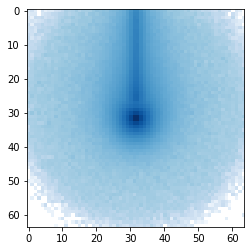

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


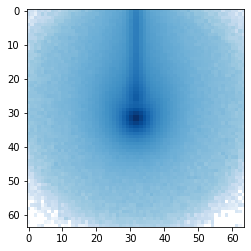

In [29]:
X = np.sum(f2, axis=0)
plt.imshow(np.log(X), cmap='Blues', label = 'QCD', filternorm=1)
plt.show()
Y = np.sum(f, axis=0)
plt.imshow(np.log(Y), cmap='Blues', label = 'SVJ', filternorm=1)
plt.show()

# Model CNN

In [26]:
inputs = tf.keras.Input(shape=(64,64))
x = inputs
x = tf.expand_dims(x,axis=-1)
x = tf.keras.layers.Conv2D(256, kernel_size=(4,4), activation='relu', input_shape=(64,64,1))(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(256, kernel_size=(4,4), activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)
modelCNN = tf.keras.Model(inputs=inputs, outputs=x, name='CNN')

In [27]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
modelCNN.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
modelCNN.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
tf_op_layer_ExpandDims_4 (Te [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 256)       4352      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 256)       1048832   
_________________________________________________________________
flatten_4 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               23888000

In [42]:
# outfile = "/home/ja2006203966/script/Network/data/H5/CNN/Train.h5"
# hf = h5py.File(outfile, 'w')
# hf.create_dataset('X_train', data=Xim_train)
# hf.create_dataset('y_train', data=yim_train)
# hf.create_dataset('X_val', data=Xim_val)
# hf.create_dataset('y_val', data=yim_val)
# hf.create_dataset('X_test', data=Xim_test)
# hf.create_dataset('y_test', data=yim_test)
# hf.close()

<HDF5 dataset "y_test": shape (40000,), type "<i8">

In [6]:
outfile = "/home/ja2006203966/script/Network/data/H5/CNN/Train.h5"
hf = h5py.File(outfile, 'r')
Xim_train = hf["X_train"][()]
yim_train = hf["y_train"][()]
Xim_val = hf["X_val"][()]
yim_val = hf["y_val"][()]
Xim_test = hf["X_test"][()]
yim_test = hf["y_test"][()]
hf.close()



In [7]:
N = 20
Nt, Nv = len(Xim_train)/N, len(Xim_val)/N
for i in range(N):
    
    Xt = np.array([Xim_train[j] for j in range(int(Nt*i),int(Nt*(i+1)) )])
    yt = np.array([yim_train[j] for j in range(int(Nt*i),int(Nt*(i+1)) )])
    Xv = np.array([Xim_val[j] for j in range(int(Nv*i),int(Nv*(i+1)) )])
    yv = np.array([yim_val[j] for j in range(int(Nv*i),int(Nv*(i+1)) )])
    modelCNN.fit(Xt, yt , validation_data=(Xv, yv), shuffle=True , epochs=1)

Epoch 1/20
375/375 [==============================] - 8s 21ms/step - loss: 0.6868 - accuracy: 0.6295 - val_loss: 0.6338 - val_accuracy: 0.6393
Epoch 2/20
375/375 [==============================] - 8s 20ms/step - loss: 0.6241 - accuracy: 0.6463 - val_loss: 0.6346 - val_accuracy: 0.6340
Epoch 3/20
375/375 [==============================] - 8s 20ms/step - loss: 0.5994 - accuracy: 0.6660 - val_loss: 0.6295 - val_accuracy: 0.6523
Epoch 4/20
217/375 [================>.............] - ETA: 2s - loss: 0.5707 - accuracy: 0.6858

KeyboardInterrupt: 

In [28]:
model_type = "CNN"
save_dir = '/home/ja2006203966/script/Network/data/H5/CNN/'
model_name = '%s_model.test.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

# progress_bar = keras.callbacks.ProgbarLogger()
csv_logger = keras.callbacks.CSVLogger(save_dir+'CNN.csv')
earlystop = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=1e-4,
                            patience=3,
                            verbose=1,
                            mode='min', baseline=None, ## 'min' 
                            restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.00001)
callbacks = [checkpoint, csv_logger,  earlystop ]


In [29]:
hist = modelCNN.fit(Xim_train, yim_train , validation_data=(Xim_val, yim_val), callbacks = callbacks, shuffle=True , epochs=20)

Epoch 1/20
7499/7500 [============================>.] - ETA: 0s - loss: 0.6190 - accuracy: 0.6607

[2020-07-30 14:22:23,606] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 145s 19ms/step - loss: 0.6190 - accuracy: 0.6607 - val_loss: 0.6001 - val_accuracy: 0.6727
Epoch 2/20
7498/7500 [============================>.] - ETA: 0s - loss: 0.5989 - accuracy: 0.6774

[2020-07-30 14:24:48,707] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 145s 19ms/step - loss: 0.5989 - accuracy: 0.6774 - val_loss: 0.5935 - val_accuracy: 0.6821
Epoch 3/20
7500/7500 [==============================] - ETA: 0s - loss: 0.5909 - accuracy: 0.6843

[2020-07-30 14:27:13,836] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 145s 19ms/step - loss: 0.5909 - accuracy: 0.6843 - val_loss: 0.5943 - val_accuracy: 0.6820
Epoch 4/20
7500/7500 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.6912

[2020-07-30 14:29:38,738] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 145s 19ms/step - loss: 0.5831 - accuracy: 0.6912 - val_loss: 0.5933 - val_accuracy: 0.6825
Epoch 5/20
7500/7500 [==============================] - ETA: 0s - loss: 0.5739 - accuracy: 0.6993

[2020-07-30 14:32:03,633] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 145s 19ms/step - loss: 0.5739 - accuracy: 0.6993 - val_loss: 0.5985 - val_accuracy: 0.6833
Epoch 6/20
7497/7500 [============================>.] - ETA: 0s - loss: 0.5618 - accuracy: 0.7081

[2020-07-30 14:34:28,387] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 145s 19ms/step - loss: 0.5618 - accuracy: 0.7081 - val_loss: 0.6068 - val_accuracy: 0.6841
Epoch 7/20
7499/7500 [============================>.] - ETA: 0s - loss: 0.5504 - accuracy: 0.7158

[2020-07-30 14:36:53,406] WARNING: Can save best model only with val_acc available, skipping.


Restoring model weights from the end of the best epoch.
7500/7500 [==============================] - 145s 19ms/step - loss: 0.5504 - accuracy: 0.7158 - val_loss: 0.6106 - val_accuracy: 0.6781
Epoch 00007: early stopping


In [38]:
from sklearn.metrics import roc_curve, auc

The area under the curves are:
AUC:0.726536679


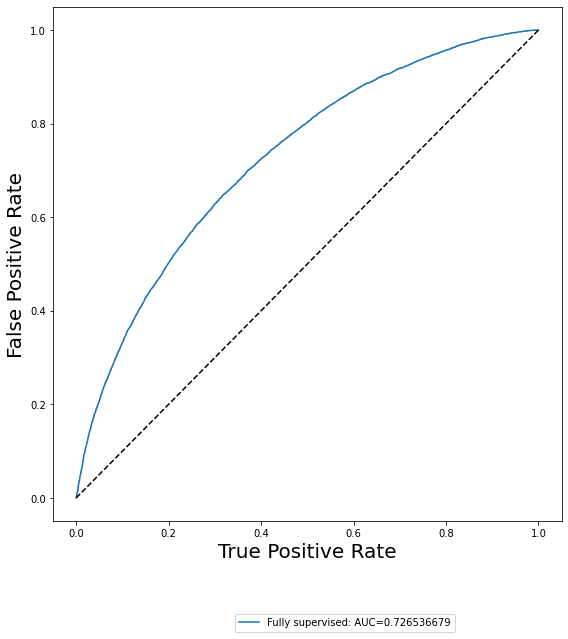

In [40]:
y_score=modelCNN.predict(Xim_test)[:,0]
# test=[i[1] for i in yim_test]
fpr , tpr , thresholds = roc_curve ( yim_test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/CNN/CNN_roc.png")
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/CNN/PR.h5", 'w')
hf.create_dataset('fpr', data=fpr)
hf.create_dataset('tpr', data=tpr)
hf.close()
# np.save("./myfpr",fpr)
# np.save("./mytpr",tpr)
plt.show()

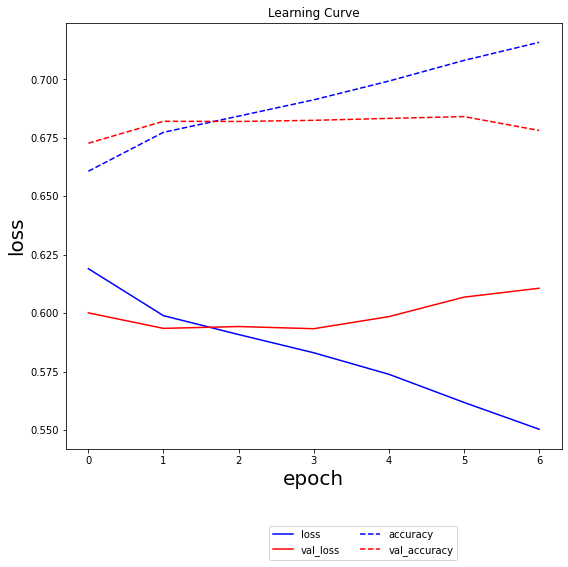

In [41]:
plt.figure(figsize=(8,8))
LOSS = pd.read_csv(save_dir+"CNN.csv")
plt.title("Learning Curve")
plt.plot(LOSS["loss"], label='loss',c='blue')
plt.plot(LOSS["val_loss"], label='val_loss',c='red')
plt.plot(LOSS["accuracy"], linestyle='--', label='accuracy',c='blue')
plt.plot(LOSS["val_accuracy"], linestyle='--', label='val_accuracy',c='red')
# plt.ylim([0.3,1])
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/CNN/CNNloss.png")

plt.show()

In [31]:
modelCNN.save('/home/ja2006203966/script/Network/data/H5/CNN/modelCNN.h5')

# Load data DNN

In [47]:
f = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/SVJ/0JSS_Jim.h5",'r')
f2 = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/QCD/0JSS_Jim.h5",'r')


In [4]:
Labels = ['T21', 'D21', 'MASS', 'D22', 'C22', 'C21']

In [6]:
JSS2 = []
N = 40
Labels = ['MASS', 'T21', 'C22', 'C21',  'D22', 'D21']
JSSd = {'MASS':[], 'T21':[], 'C22':[], 'C21':[],  'D22':[], 'D21':[]}
JSSd2 = {'MASS':[], 'T21':[], 'C22':[], 'C21':[],  'D22':[], 'D21':[]}

for lb in Labels:
    for i in range(N):
        jss = h5py.File("/home/ja2006203966/script/Network/data/H5/SVJ/rinv03/"+str(i)+"JSS_Jim.h5",'r')
        jss = jss[lb][()].tolist()
        JSSd[lb] = JSSd[lb] + jss
        
        jss2 = h5py.File("/home/ja2006203966/script/Network/data/H5/QCD/"+str(i)+"JSS_Jim.h5",'r')
        jss2 = jss2[lb][()].tolist()
        JSSd2[lb] = JSSd2[lb] + jss2

In [9]:
f.shape

(6, 207573)

In [8]:
f = np.array([ JSSd[i] for i in Labels])
f2 = np.array([ JSSd2[i] for i in Labels])
f = f.transpose((1,0))
f2 = f2.transpose((1,0))

In [11]:
f = np.array([f[i] for i in range(200000)])
f2 = np.array([f2[i] for i in range(200000)])

In [12]:
ft = np.append(f,f2, axis=0)

In [13]:
yt = np.array([1 for i in range(len(f))]+[0 for i in range(len(f2))])

In [15]:
ft.shape

(400000, 6)

## Seperate data

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(ft, yt, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.25)

## Save training data

In [17]:
# outfile = "/home/ja2006203966/script/Network/data/H5/DNN/Train.h5"
# hf = h5py.File(outfile, 'w')
# hf.create_dataset('X_train', data=X_train)
# hf.create_dataset('y_train', data=y_train)
# hf.create_dataset('X_val', data=X_val)
# hf.create_dataset('y_val', data=y_val)
# hf.create_dataset('X_test', data=X_test)
# hf.create_dataset('y_test', data=y_test)
# hf.close()

## Load data

In [ ]:
outfile = "/home/ja2006203966/script/Network/data/H5/DNN/Train.h5"
hf = h5py.File(outfile, 'r')
X_train = hf["X_train"][()]
y_train = hf["y_train"][()]
X_val = hf["X_val"][()]
y_val = hf["y_val"][()]
X_test = hf["X_test"][()]
y_test = hf["y_test"][()]
hf.close()



# Model DNN

In [45]:
inputs = tf.keras.Input(shape=(6,))
x = inputs
x = tf.keras.layers.Dense(6, activation='relu')(x)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)
modelDNN = tf.keras.Model(inputs=inputs, outputs=x, name='DNN')

In [46]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
modelDNN.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
modelDNN.summary()

Model: "DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_23 (Dense)             (None, 256)               1792      
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 514       
Total params: 2,348
Trainable params: 2,348
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_type = "DNN"
save_dir = '/home/ja2006203966/script/Network/data/H5/DNN/'
model_name = '%s_model.test.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

# progress_bar = keras.callbacks.ProgbarLogger()
csv_logger = keras.callbacks.CSVLogger(save_dir+'DNN.csv')
earlystop = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=1e-4,
                            patience=3,
                            verbose=1,
                            mode='min', baseline=None, ## 'min' 
                            restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.00001)
callbacks = [checkpoint, csv_logger,  earlystop ]


In [48]:
modelDNN.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=callbacks, shuffle=True , epochs=20)

Epoch 1/20
7500/7500 [==============================] - ETA: 0s - loss: 0.6478 - accuracy: 0.6279

[2020-07-30 15:21:27,477] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 31s 4ms/step - loss: 0.6478 - accuracy: 0.6279 - val_loss: 0.6370 - val_accuracy: 0.6417
Epoch 2/20
7488/7500 [============================>.] - ETA: 0s - loss: 0.6312 - accuracy: 0.6508

[2020-07-30 15:21:59,038] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 32s 4ms/step - loss: 0.6312 - accuracy: 0.6508 - val_loss: 0.6244 - val_accuracy: 0.6567
Epoch 3/20
7492/7500 [============================>.] - ETA: 0s - loss: 0.6237 - accuracy: 0.6567

[2020-07-30 15:22:31,391] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 32s 4ms/step - loss: 0.6237 - accuracy: 0.6566 - val_loss: 0.6199 - val_accuracy: 0.6606
Epoch 4/20
7486/7500 [============================>.] - ETA: 0s - loss: 0.6207 - accuracy: 0.6602

[2020-07-30 15:23:02,512] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 31s 4ms/step - loss: 0.6206 - accuracy: 0.6602 - val_loss: 0.6174 - val_accuracy: 0.6638
Epoch 5/20
7495/7500 [============================>.] - ETA: 0s - loss: 0.6191 - accuracy: 0.6617

[2020-07-30 15:23:33,700] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 31s 4ms/step - loss: 0.6190 - accuracy: 0.6617 - val_loss: 0.6167 - val_accuracy: 0.6637
Epoch 6/20
7484/7500 [============================>.] - ETA: 0s - loss: 0.6184 - accuracy: 0.6625

[2020-07-30 15:24:04,915] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 31s 4ms/step - loss: 0.6184 - accuracy: 0.6626 - val_loss: 0.6173 - val_accuracy: 0.6648
Epoch 7/20
7490/7500 [============================>.] - ETA: 0s - loss: 0.6175 - accuracy: 0.6637

[2020-07-30 15:24:36,370] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 31s 4ms/step - loss: 0.6175 - accuracy: 0.6637 - val_loss: 0.6157 - val_accuracy: 0.6667
Epoch 8/20
7485/7500 [============================>.] - ETA: 0s - loss: 0.6174 - accuracy: 0.6641

[2020-07-30 15:25:07,745] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 31s 4ms/step - loss: 0.6174 - accuracy: 0.6641 - val_loss: 0.6202 - val_accuracy: 0.6601
Epoch 9/20
7486/7500 [============================>.] - ETA: 0s - loss: 0.6173 - accuracy: 0.6635

[2020-07-30 15:25:38,221] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 30s 4ms/step - loss: 0.6172 - accuracy: 0.6635 - val_loss: 0.6146 - val_accuracy: 0.6678
Epoch 10/20
7494/7500 [============================>.] - ETA: 0s - loss: 0.6170 - accuracy: 0.6639

[2020-07-30 15:26:09,529] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 31s 4ms/step - loss: 0.6170 - accuracy: 0.6639 - val_loss: 0.6171 - val_accuracy: 0.6635
Epoch 11/20
7492/7500 [============================>.] - ETA: 0s - loss: 0.6168 - accuracy: 0.6650

[2020-07-30 15:26:41,280] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 32s 4ms/step - loss: 0.6168 - accuracy: 0.6650 - val_loss: 0.6148 - val_accuracy: 0.6669
Epoch 12/20
7487/7500 [============================>.] - ETA: 0s - loss: 0.6167 - accuracy: 0.6651

[2020-07-30 15:27:12,164] WARNING: Can save best model only with val_acc available, skipping.


Restoring model weights from the end of the best epoch.
7500/7500 [==============================] - 31s 4ms/step - loss: 0.6167 - accuracy: 0.6651 - val_loss: 0.6168 - val_accuracy: 0.6652
Epoch 00012: early stopping


In [49]:
from sklearn.metrics import roc_curve, auc

The area under the curves are:
AUC:0.720246038


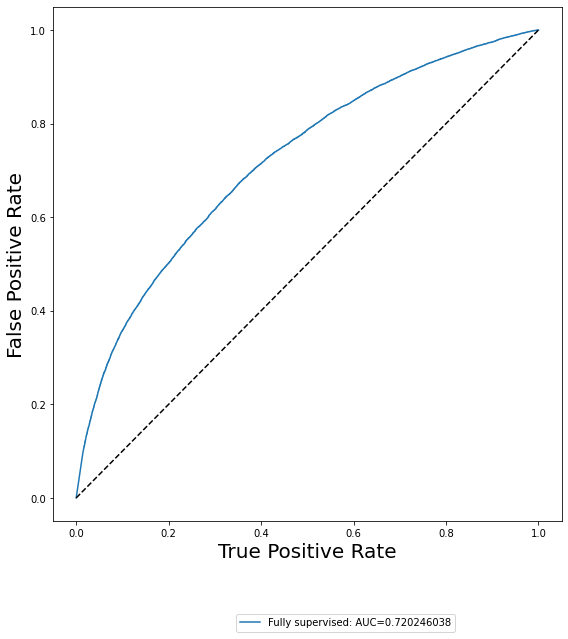

In [50]:
y_score=modelDNN.predict(X_test)[:,0]
# test=[i[1] for i in yim_test]
fpr , tpr , thresholds = roc_curve ( y_test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/DNN/DNN_roc.png")
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/DNN/PR.h5", 'w')
hf.create_dataset('fpr', data=fpr)
hf.create_dataset('tpr', data=tpr)
hf.close()
# np.save("./myfpr",fpr)
# np.save("./mytpr",tpr)
plt.show()

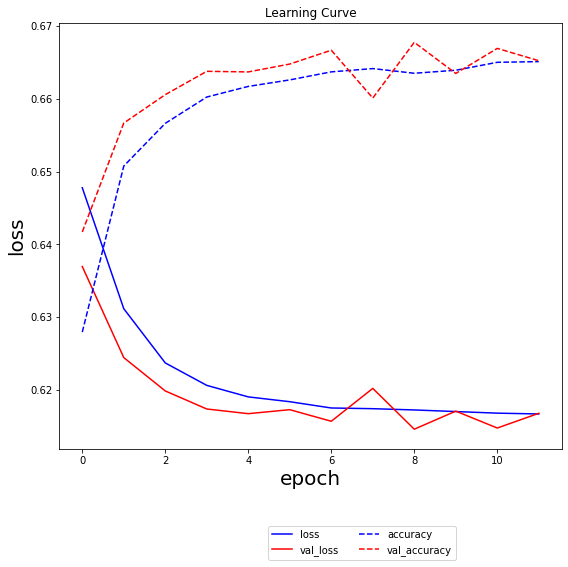

In [51]:
plt.figure(figsize=(8,8))
LOSS = pd.read_csv(save_dir+"DNN.csv")
plt.title("Learning Curve")
plt.plot(LOSS["loss"], label='loss',c='blue')
plt.plot(LOSS["val_loss"], label='val_loss',c='red')
plt.plot(LOSS["accuracy"], linestyle='--', label='accuracy',c='blue')
plt.plot(LOSS["val_accuracy"], linestyle='--', label='val_accuracy',c='red')
# plt.ylim([0.3,1])
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/DNN/DNNloss.png")

plt.show()

In [52]:
modelDNN.save('/home/ja2006203966/script/Network/data/H5/DNN/modelDNN.h5')

# Load 2CNN data

In [53]:
N=40
# Jim = np.array([np.zeros((64,64))])
# Jim2 = np.array([np.zeros((64,64))])
Jim = []
Jim2 = []
JSSd = {'MASS':[], 'T21':[], 'C22':[], 'C21':[],  'D22':[], 'D21':[]}
JSSd2 = {'MASS':[], 'T21':[], 'C22':[], 'C21':[],  'D22':[], 'D21':[]}
Labels = ['MASS', 'T21', 'C22', 'C21',  'D22', 'D21']
for i in tqdm(range(N)):
    f = h5py.File("/home/ja2006203966/script/Network/data/H5/SVJ/rinv03/"+str(i)+"JSS_Jim.h5",'r')
    
    fin = np.array(f['jetim_index'][()])
    fsin = np.array(f['jss_index'][()])
    fcin = set(f['jss_index'][()])&set(f['jetim_index'][()])
    fci = [(i in fcin) for i in fin]
    fcs = [(i in fcin) for i in fsin]

    fim = f['jetim'][()]
    # fim = [i for i in fim]
    fim = [fim[i] for i in range(len(fci)) if fci[i]]
    
    f2 = h5py.File("/home/ja2006203966/script/Network/data/H5/QCD/"+str(i)+"JSS_Jim.h5",'r')
    fin2 = np.array(f2['jetim_index'][()])
    fsin2 = np.array(f2['jss_index'][()])
    fcin2 = set(f2['jss_index'][()])&set(f2['jetim_index'][()])
    fci2 = [(i in fcin2) for i in fin2]
    fcs2 = [(i in fcin2) for i in fsin2]
    
    fim2 = f2['jetim'][()]
    fim2 =  [fim2[i] for i in range(len(fci2)) if fci2[i]]
    
    Jim = Jim +fim
    Jim2 = Jim2+fim2
#     Jim = np.append(Jim,fim, axis=0)
#     Jim2 = np.append(Jim2,fim2, axis=0)
    
    for lb in Labels:
        jss = [f[lb][()][i] for i in range(len(fcs)) if fcs[i]]
#         jss = f[lb][()].tolist()
        JSSd[lb] = JSSd[lb] + jss
        
        jss2 = [f2[lb][()][i] for i in range(len(fcs2)) if fcs2[i]]

#         jss2 = f2[lb][()].tolist()
        JSSd2[lb] = JSSd2[lb] + jss2
    
    
    
    
    



100%|██████████| 40/40 [18:30<00:00, 27.76s/it]


In [59]:
fs = np.array([ JSSd[i] for i in Labels])
fs2 = np.array([ JSSd2[i] for i in Labels])
fs = fs.transpose((1,0))
fs2 = fs2.transpose((1,0))
fi = np.array(Jim)
fi2 = np.array(Jim2)

In [61]:
(fs.shape,fi.shape, fs2.shape, fi2.shape)

((206567, 6), (206567, 64, 64), (395128, 6), (395128, 64, 64))

In [62]:
fs = np.array([fs[i] for i in range(200000) ])
fs2 = np.array([fs2[i] for i in range(200000) ])
fi = np.array([fi[i] for i in range(200000) ])
fi2 = np.array([fi2[i] for i in range(200000) ])

In [63]:
ft = np.append(fs,fs2, axis=0)
ftim = np.append(fi,fi2, axis=0)

In [73]:
fc[0][0].shape

(6,)

In [79]:
yt = np.array([1 for i in range(len(fs))]+[0 for i in range(len(fs2))])

In [78]:
yt.shape

(18,)

In [80]:
fc = np.array([(ft[i],ftim[i]) for i in range(len(ft))])

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(fc, yt, test_size=0.4)
# X_train, X_val, y_train, y_val = train_test_split(ft, yt, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.25)

In [83]:
X_train1 = X_train.transpose(1,0)[0]
X_train2 = X_train.transpose(1,0)[1]
X_val1 = X_val.transpose(1,0)[0]
X_val2 = X_val.transpose(1,0)[1]
X_test1 = X_test.transpose(1,0)[0]
X_test2 = X_test.transpose(1,0)[1]

In [84]:
X_train1 = np.array([i for i in X_train1])
X_train2 = np.array([i for i in X_train2])
X_val1 = np.array([i for i in X_val1])
X_val2 = np.array([i for i in X_val2])
X_test1 = np.array([i for i in X_test1])
X_test2 = np.array([i for i in X_test2])

In [85]:
X_train1.shape

(240000, 6)

## Save Training data

In [86]:
# outfile = "/home/ja2006203966/script/Network/data/H5/2CNN/Train.h5"
# hf = h5py.File(outfile, 'w')
# hf.create_dataset('X_train_jss', data=X_train1)
# hf.create_dataset('X_val_jss', data=X_val1)
# hf.create_dataset('X_test_jss', data=X_test1)
# hf.create_dataset('X_train_jim', data=X_train2)
# hf.create_dataset('X_val_jim', data=X_val2)
# hf.create_dataset('X_test_jim', data=X_test2)

# hf.create_dataset('y_train', data=y_train)
# hf.create_dataset('y_val', data=y_val)
# hf.create_dataset('y_test', data=y_test)
# hf.close()

## Load data

In [ ]:
outfile = "/home/ja2006203966/script/Network/data/H5/2CNN/Train.h5"
hf = h5py.File(outfile, 'r')
X_train1 = hf["X_train_jss"][()]
X_val1 = hf["X_val_jss"][()]
X_test1 = hf["X_test_jss"][()]
X_train2 = hf["X_train_jim"][()]
X_val2 = hf["X_val_jim"][()]
X_test2 = hf["X_test_jim"][()]


y_train = hf["y_train"][()]
y_val = hf["y_val"][()]
y_test = hf["y_test"][()]

hf.close()

# Model 2CNN

In [103]:
inputs = tf.keras.Input(shape=(6,))
x = inputs
x = tf.keras.layers.Dense(36, activation='relu')(x)

# x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(1)(x)

inputs2 = tf.keras.Input(shape=(64,64))
x2 = inputs2
x2 = tf.expand_dims(x2,axis=-1)
x2 = tf.keras.layers.Conv2D(256, kernel_size=(1,1), activation='relu', input_shape=(64,64,1))(x2)
x2 = tf.keras.layers.MaxPooling2D()(x2)
x2 = tf.keras.layers.Conv2D(128, kernel_size=(4,4), activation='relu')(x2)
x2 = tf.keras.layers.MaxPooling2D()(x2)
x2 = tf.keras.layers.Flatten()(x2)
# x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
# x2 = tf.keras.layers.Dropout(0.2)(x2)
# x2 = tf.keras.layers.Dense(1)(x2)

xt = tf.concat([x,x2], axis=-1)
xt = tf.keras.layers.Dense(128, activation='relu')(xt)
xt = tf.keras.layers.Dropout(0.2)(xt)
xt = tf.keras.layers.Dense(2, activation='sigmoid')(xt)




model2CNN = tf.keras.Model(inputs=(inputs, inputs2), outputs=xt, name='2CNN')

In [104]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model2CNN.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model2CNN.summary()

Model: "2CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_5 (Tenso [(None, 64, 64, 1)]  0           input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 64, 256)  512         tf_op_layer_ExpandDims_5[0][0]   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 32, 32, 256)  0           conv2d_10[0][0]                  
_______________________________________________________________________________________________

In [105]:
model_type = "2CNN"
save_dir = '/home/ja2006203966/script/Network/data/H5/2CNN/'
model_name = '%s_model.test.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

# progress_bar = keras.callbacks.ProgbarLogger()
csv_logger = keras.callbacks.CSVLogger(save_dir+'2CNN.csv')
earlystop = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=1e-4,
                            patience=3,
                            verbose=1,
                            mode='min', baseline=None, ## 'min' 
                            restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.00001)
callbacks = [checkpoint, csv_logger,  earlystop ]


In [106]:
model2CNN.fit((X_train1,X_train2), y_train, callbacks = callbacks, validation_data=((X_val1,X_val2), y_val), shuffle=True , epochs=20)

Epoch 1/20
7498/7500 [============================>.] - ETA: 0s - loss: 0.6832 - accuracy: 0.5940

[2020-07-30 16:47:27,079] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 106s 14ms/step - loss: 0.6833 - accuracy: 0.5940 - val_loss: 0.8087 - val_accuracy: 0.5047
Epoch 2/20
7500/7500 [==============================] - ETA: 0s - loss: 0.7191 - accuracy: 0.5784

[2020-07-30 16:49:13,359] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 106s 14ms/step - loss: 0.7191 - accuracy: 0.5784 - val_loss: 0.6817 - val_accuracy: 0.6107
Epoch 3/20
7500/7500 [==============================] - ETA: 0s - loss: 0.6865 - accuracy: 0.5894

[2020-07-30 16:51:00,277] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 107s 14ms/step - loss: 0.6865 - accuracy: 0.5894 - val_loss: 0.6783 - val_accuracy: 0.5887
Epoch 4/20
7498/7500 [============================>.] - ETA: 0s - loss: 0.6831 - accuracy: 0.5529

[2020-07-30 16:52:47,273] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 107s 14ms/step - loss: 0.6831 - accuracy: 0.5529 - val_loss: 0.6776 - val_accuracy: 0.5896
Epoch 5/20
7497/7500 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.6000

[2020-07-30 16:54:34,307] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 107s 14ms/step - loss: 0.6838 - accuracy: 0.6000 - val_loss: 0.6813 - val_accuracy: 0.6162
Epoch 6/20
7496/7500 [============================>.] - ETA: 0s - loss: 0.6861 - accuracy: 0.5964

[2020-07-30 16:56:27,951] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 114s 15ms/step - loss: 0.6861 - accuracy: 0.5964 - val_loss: 0.6792 - val_accuracy: 0.5558
Epoch 7/20
7500/7500 [==============================] - ETA: 0s - loss: 0.6782 - accuracy: 0.5816

[2020-07-30 16:58:31,505] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 124s 16ms/step - loss: 0.6782 - accuracy: 0.5816 - val_loss: 0.6774 - val_accuracy: 0.5957
Epoch 8/20
7499/7500 [============================>.] - ETA: 0s - loss: 0.6799 - accuracy: 0.6090

[2020-07-30 17:00:47,712] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 136s 18ms/step - loss: 0.6799 - accuracy: 0.6090 - val_loss: 0.6752 - val_accuracy: 0.5931
Epoch 9/20
7500/7500 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.6044

[2020-07-30 17:02:42,090] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 114s 15ms/step - loss: 0.6842 - accuracy: 0.6044 - val_loss: 0.6773 - val_accuracy: 0.6167
Epoch 10/20
7500/7500 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.5983

[2020-07-30 17:04:28,361] WARNING: Can save best model only with val_acc available, skipping.


7500/7500 [==============================] - 106s 14ms/step - loss: 0.6768 - accuracy: 0.5983 - val_loss: 0.6751 - val_accuracy: 0.5800
Epoch 11/20
7500/7500 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.6085

[2020-07-30 17:06:14,531] WARNING: Can save best model only with val_acc available, skipping.


Restoring model weights from the end of the best epoch.
7500/7500 [==============================] - 106s 14ms/step - loss: 0.6789 - accuracy: 0.6085 - val_loss: 0.6793 - val_accuracy: 0.6181
Epoch 00011: early stopping


In [107]:
from sklearn.metrics import roc_curve, auc

The area under the curves are:
AUC:0.721005567


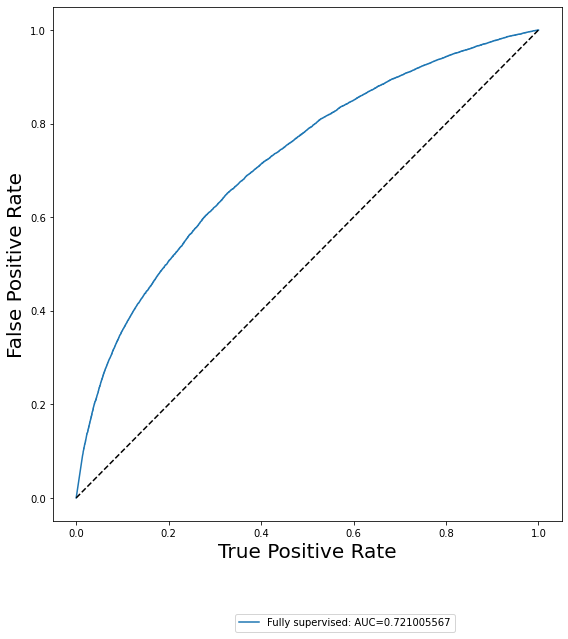

In [108]:
y_score=modelDNN.predict((X_test1,X_test2))[:,0]
# test=[i[1] for i in yim_test]
fpr , tpr , thresholds = roc_curve ( y_test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/2CNN/2CNN_roc.png")
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/2CNN/PR.h5", 'w')
hf.create_dataset('fpr', data=fpr)
hf.create_dataset('tpr', data=tpr)
hf.close()
# np.save("./myfpr",fpr)
# np.save("./mytpr",tpr)
plt.show()

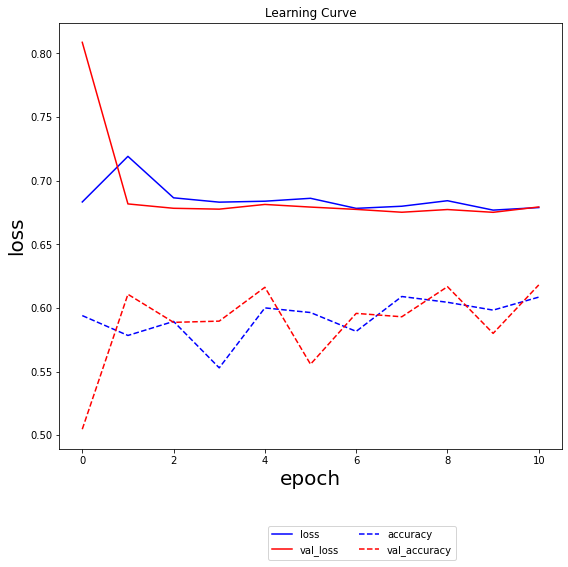

In [109]:
plt.figure(figsize=(8,8))
LOSS = pd.read_csv(save_dir+"2CNN.csv")
plt.title("Learning Curve")
plt.plot(LOSS["loss"], label='loss',c='blue')
plt.plot(LOSS["val_loss"], label='val_loss',c='red')
plt.plot(LOSS["accuracy"], linestyle='--', label='accuracy',c='blue')
plt.plot(LOSS["val_accuracy"], linestyle='--', label='val_accuracy',c='red')
# plt.ylim([0.3,1])
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/2CNN/2CNNloss.png")

plt.show()

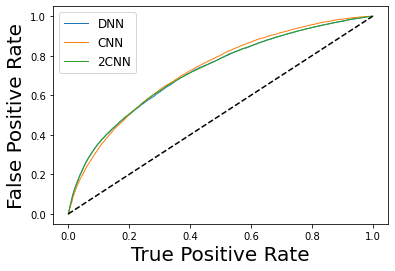

In [113]:
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/DNN/PR.h5", 'r')
tpr1 = hf["tpr"][()]
fpr1 = hf["fpr"][()]
hf.close()
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/CNN/PR.h5", 'r')
tpr2 = hf["tpr"][()]
fpr2 = hf["fpr"][()]
hf.close()
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/2CNN/PR.h5", 'r')
tpr3 = hf["tpr"][()]
fpr3 = hf["fpr"][()]
hf.close()

plt.plot(tpr1,fpr1, linewidth=1, label='DNN')
plt.plot(tpr2,fpr2, linewidth=1, label='CNN')
plt.plot(tpr3,fpr3, linewidth=1, label='2CNN')
plt.legend(prop={'size': 12}) # plot label tag
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.savefig("/home/ja2006203966/script/Network/data/H5/ALL_ROC.png")
plt.show()



# Back up

In [ ]:
# y_test=[i[1] for i in testpojen_datay]
X_test = np.load("./X_test.npy",allow_pickle=True)
X_test = X_test.item()
y_test = np.load("./y_test.npy",allow_pickle=True)
y_score=model.predict(X_test)[:,0]
test=[i[1] for i in y_test]
fpr , tpr , thresholds = roc_curve ( test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('1-False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./Myneighnorhood_Particlenet_roc.png")
np.save("./myfpr",fpr)
np.save("./mytpr",tpr)
#plt.close()
 
# plt.subplot(2,1,2) 
# LOSS = pd.read_csv('./training_log.csv')
# plt.plot(LOSS["loss"], label='loss',c='blue')
# plt.plot(LOSS["val_loss"], label='val_loss',c='red')
# plt.ylabel('loss',fontsize=20)
# plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
# plt.tight_layout()

#plt.savefig("./plot_3.png")
#plt.close()
plt.show()

# Papaer's CNN

In [ ]:
def data_generator(h5file1, h5file2, batchsize, hlindices, start=0, stop=None):
    stop = ((stop-start) // batchsize) * batchsize + start
    assert (stop-start) % batchsize     == 0  # Batches will not exceed stop.

    with h5py.File(h5file1, 'r') as f1, h5py.File(h5file2, 'r') as f2:
        assert f1['features'].shape[0] >= stop
        assert f1['features'].shape[0] == f1['targets'].shape[0]
        assert f1['features'].shape[0] == f2['features'].shape[0]
        assert f1['targets'].shape[0] == f2['targets'].shape[0]
        iexample = start
        
        while True:
            assert iexample >= start
            assert iexample+batchsize <= stop
            batch = slice(iexample, iexample + batchsize)

            X  = f1['features'][batch] # Images.
            Y  = f1['targets'][batch]
            #X2 = f2['features'][batch][:, hlindices] # High-level.
            #Y2 = f2['targets'][batch]  
            #assert np.all(Y == Y2)
            
            X = np.log(1.0+X) / 4.0 
            
            #yield X, Y
            #yield {'input_0':X, 'input_1':X2}, {'output':Y}
            yield {'input_0':X}, {'output':Y}
            
            iexample += batchsize
            if iexample >= stop:
                assert iexample == stop
                iexample = start
    

def train():
    ###############################################################################
    # Dataset                                                                     #
    ###############################################################################
    #filename = '/home/pjsadows//ml/data/physics/jets/download4/datasets/train_no_pile_10000000.h5'
    hlindices = np.array(['mass', 'c1b1']) # Order of features: mass, c1b1,c2b2,d1b2,d2b2, tau

    #filename  = '/Volumes/Free Space/images/train_no_pile_10000000.h5'
    #filename2 = '/Volumes/Free Space/highlevel/train_no_pile_10000000.h5'

    filename  = './train2_no_pile_10000000.h5' #image input
    filename2 = './train_no_pile_10000000.h5' #high level features input

    N_train, N_valid = 9500000, 500000
    generator = data_generator(filename, filename2, batchsize=100, hlindices=hlindices, start=0, stop=N_train)
    validation_data = data_generator(filename, filename2, batchsize=100, hlindices=hlindices, start=N_train, stop=N_train+N_valid)

    #filename_test  = '/Volumes/Free Space/images/test_no_pile_5000000.h5'
    #filename2_test = '/Volumes/Free Space/highlevel/test_no_pile_5000000.h5'

    filename_test  = './test2_no_pile_5000000.h5'
    filename2_test = './test_no_pile_5000000.h5'

    N_test = 5000000
    generator_test = data_generator(filename_test, filename2_test, batchsize=100, hlindices=hlindices, start=0, stop=N_test)

    ###############################################################################
    # Model                                                                       #
    ###############################################################################
    act  = 'relu' 
    init = 'glorot_normal' #'glorot_normal'#'he_normal'
    width = 500 #500 
    # Image arm
    nconv  = 4
    nch    = 32
    # Head
    nhead = 4
    ndo   = 2 
    
    # Arm 0: images
    input_0 = Input(shape=(1,32,32), dtype='float32', name='input_0') # We can name an layer by passing name.
    x0 = input_0
    for i in range(nconv):
        x0 = Convolution2D(nch,1, subsample=(1,1), border_mode='valid', init=init, activation=act)(x0) # nch, 4, 4
    x0 = Flatten()(x0) 

    # Arm 1: high-level variables.
    #input_1  = Input(shape=(len(hlindices),), name='input_1')
    #x1 = input_1
    #for i in range(nhl):
    #    x1 = Dense(width, init=init, activation=act)(x1)

    # Head
    #x = merge([x0, x1], mode='concat')
    x = x0
    for i in range(nhead):
        x = Dense(width, activation=act, init=init)(x)
        if i >= nhead - ndo:
            x = Dropout(p=0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)

    # Model
    #model = Model(input=[input_0, input_1], output=[output])
    model = Model(input=[input_0], output=[output])
    lrinit  = 0.0001 
    lrdecay = 0.8
    optimizer = Adam(lr=lrinit, beta_1=0.99, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer,loss={'output':'binary_crossentropy'}, metrics=['accuracy'])

    ###############################################################################
    # Algorithm                                                                   #
    ###############################################################################
    def lr_scheduler(epoch):
        return lrinit * lrdecay ** epoch
    lrschedule = LearningRateScheduler(lr_scheduler)
    stopping   = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='min') 
    cbks = [stopping, lrschedule]

    # Copy script so that we can reconstruct model later.
    filebase = './images_conv%d_dense%d_nch%d_do%d_width%d_%s_lrd%d_%d' % (nconv, nhead, nch, ndo, width, act, lrdecay*100, np.random.randint(1000))
    fileout = filebase + '.py'
    os.system('cp %s %s' % (filebase, fileout))
    print('Saving to %s' % fileout)
    
    # Train.
    nb_epoch  = 1000
    history = model.fit_generator(generator, samples_per_epoch=N_train, nb_epoch=nb_epoch, verbose=1, validation_data=validation_data, nb_val_samples=N_valid, class_weight=None, callbacks=cbks) 

    # Save model.
    fileout = filebase + '.h5'
    model.save_weights(fileout, overwrite=True)
    # Save pkl.
    fileout = filebase + '.pkl'
    with open(fileout, 'w') as f:
        pickle.dump(history.history, f)
    # Save .yaml script.
    fileout = filebase + '.yaml'
    with open(fileout, 'w') as f:
        f.write(model.to_yaml())

    # Compute test error accuracy.
    vals = model.evaluate_generator(generator_test, val_samples=N_test, max_q_size=10)
    for name, val in zip(model.metrics_names, vals):
        print('test_%s: %f' % (name, val))
        history.history['test_' + name] = val
    # Compute AUC
    #auc = compute_auc(model, generator_test, val_samples=N_test)
    #print 'Test AUC: %f' % auc
    #history.history['test_auc'] = auc

    # Save pkl.
    fileout = filebase + '.pkl'
    with open(fileout, 'w') as f:
        pickle.dump(history.history, f)


    return history.history['val_loss'][-1]

# if __name__=='__main__':
#     loss = train()
#     print(loss)
